# HW 11 : Deploy Your Model




## การ Deploy โมเดลเพื่อนำไปใช้งานจริง

ในส่วนนี้เราจะมาทำการ Deploy ตัวโมเดลต่างๆ ที่เราทำมาทำเป็น Intent chatbot ทั้งในรูปแบบของ

1.    **Text Classification** (Topic, Intent-based classification) เราจะใช้โมเดล Pretrained LM model (Thai2fit) + DNN ก็แล้วกันจะได้ง่ายๆ
2.   **Chatbot**: เราจะผสมผสานหลายๆ อย่างที่เรียนมา มาทำเป็น Chatbot ถามตอบเกี่ยวกับวิทยาลัย



# Deploy Text Clssification model (Sentiment Analysis)

## Train your model

ตัวอย่างนี้เป็นตัวอย่างโค้ดโมเดจาก HW6 มาใช้งาน นะครับ โดยจะตัอง save model และ dict ที่แมพจาก คำเป็น id

In [ ]:
!pip install pythainlp
!pip install torch==1.4.0
!pip install torchtext==0.6.0

import torchtext
torchtext.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 16.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torch==1.4.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1)
ERROR: No matching distribution found for torch==1.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


'0.6.0'

In [ ]:
#download data
!wget https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/pos.txt
!wget https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/neg.txt
!wget https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/neu.txt

--2024-02-23 06:26:03--  https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/pos.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 761195 (743K) [text/plain]
Saving to: ‘pos.txt’

pos.txt             100%[===================>] 743.35K  --.-KB/s    in 0.04s   

2024-02-23 06:26:03 (18.3 MB/s) - ‘pos.txt’ saved [761195/761195]

--2024-02-23 06:26:03--  https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/neg.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1676577 (1.6M) [text/plain]
Saving 

In [ ]:
import pandas as pd

neg_df = pd.read_csv('neg.txt',sep='\t',names=['text'], header=None)
neg_df["label"] = "neg"

pos_df = pd.read_csv('pos.txt',sep='\t',names=['text'], header=None)
pos_df["label"] = "pos"

#neu_df = pd.read_csv('neu.txt',sep=';',names=['review'], header=None)
#neu_df["sentiment"] = "neu"
df = pd.concat([neg_df, pos_df])

In [ ]:
df

,text,label
0,☹️,neg
1,😔,neg
2,😞,neg
3,😥,neg
4,รำ,neg
...,...,...
4773,พูดถึงรถยนต์ตัวท็อปที่อีซูซุผลิต หนึ่งในนั้นต้...,pos
4774,เรื่องประทับใจเกิดที่ the mall บางแค ค่ะ ❤️ เป...,pos
4775,🌞แสงแดดเมืองไทย โดยเฉพาะหน้าร้อนอย่างเดือนเมษา...,pos
4776,เราชื่นชอบและเป็นลูกค้าที่ใช้บริการ มานานถึง 3...,pos


In [ ]:
# Training configurations
SEED = 1234
TRAIN = False
BATCH_SIZE = 64
N_EPOCHS = 10

# Architecture
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 2
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

TEXT = "ไม่อร่อยเลย"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# Bert model and its tokenizer
# Text data
from torchtext import data, datasets
# Numerical computation
import numpy as np
# standard library
import random
import time
# Configuration
#from config import *

# Set random seed for reproducible experiments
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

import pandas as pd
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

In [ ]:
from pythainlp.tokenize import word_tokenize
import re

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def thai_clean_text(text):
    st = ""

    #สามารถเพิ่มโค้ด สำหรับคลีน ข้อความ เช่น ลบ emoji ออก เป็นต้น
    text = deEmojify(text)
    text = text.replace("\n"," ")
    for w in word_tokenize(text):
        st = st + w + " "

    return  re.sub(' +', ' ', st)

df['text'] = df.text.apply(thai_clean_text)
df = df.dropna()

In [ ]:
import numpy as np

import time
import random
import functools
import math

from torchtext.data import Field, Dataset, Example
import pandas as pd

class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""
    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.examples = examples.apply(SeriesExample.fromSeries, args=(fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        self.fields = dict(fields)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""

    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()

        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [ ]:
reviews = df['text'].values
labels = df['label'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels,test_size=0.2, random_state=1234)

In [ ]:
import pandas as pd
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

In [ ]:
init_token_id = 1  #เริ่มต้นประโยค
pad_token_id = 0  #pad_id ตอนเทรนจะเติมเข้าไปกรณีบางประโยคสั้นกว่าประโยคอื่น
unk_token_id=2 # กรณีไม่พบคำศัพท์จะแทนด้วย 2 นี้
max_input_len = 512 # ความยาวสูงสุดที่โมเดลสามารภทำนายได้

#create vocab_dict
vocab = []
for i in range( train_sentences.shape[0]):
    ws = train_sentences[i].split(" ")
    for w in ws:
        if w not in vocab:
            vocab.append(w)


In [ ]:
vocab.sort()
start_word_id = 3
token_to_id = {val: (i+start_word_id) for i, val in enumerate(vocab)}

token_to_id.update({'init_id': init_token_id, 'pad_id':pad_token_id,'unk_id':unk_token_id})

In [ ]:
# token_to_id

In [ ]:
import json
vocab_json_object = json.dumps(token_to_id)
with open("token2idx.json", "w") as outfile:
    outfile.write(vocab_json_object)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [ ]:
import json
import numpy as np

import time
import random
import functools
import math

from torchtext.data import Field, Dataset, Example,LabelField
import pandas as pd

# Tokensize and crop sentence to 510 (for 1st and last token) instead of 512 (i.e. `max_input_len`)
def tokenize_and_crop(sentence):
  #print(sentence)
  tokens = sentence.split(" ")
  tokens = tokens[:max_input_len - 2]
  return tokens

def convert_tokens_to_ids(tokens):
    out_id = []
    for w in tokens:
        if w in token_to_id.keys():
            out_id.append(token_to_id[w])
        else:
            out_id.append(unk_token_id) #unk word
    if len(out_id)==0:
        return [0]
    return out_id

def load_data():
  text = Field(
    batch_first=True,
    use_vocab=False,
    tokenize=tokenize_and_crop,
    preprocessing=convert_tokens_to_ids,
    init_token=init_token_id,
    pad_token=pad_token_id,
    unk_token=unk_token_id
  )

  label = LabelField(dtype=torch.long)


  fields = { 'text' : text, 'label' : label }

  train_ds = DataFrameDataset(df, fields)
  _train_data, _valid_data = train_ds.split(random_state=random.seed(1234))

  #แบ่งครึ่งๆ
  test_data,valid_data = _valid_data.split(random_state=random.seed(1234),split_ratio=0.5)


  print(f"training examples count: {len(_train_data)}")
  print(f"test examples count: {len(test_data)}")
  print(f"validation examples count: {len(valid_data)}")

  label.build_vocab(_train_data)

  lab_data = {v: k for k, v in label.vocab.stoi.items()}
  with open('idx2lab.json', 'w') as f:
      json.dump(lab_data, f)



  train_iter, valid_iter, test_iter = data.BucketIterator.splits(
    (_train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True
  )

  return train_iter, valid_iter, test_iter

In [ ]:
# Sentiment model contrain two-GRU layers for analyzing hidden representation
# and a linear layer for classfification (the sigmoid is applied by the criterion during training).
import torch.nn as nn

class SentimentModel(nn.Module):
  def __init__(
    self,
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout,
    padding_id=0
  ):

    super(SentimentModel, self).__init__()

    embedding_dim = embedding_dim
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_id)

    self.rnn = nn.GRU(
      embedding_dim,
      hidden_dim,
      num_layers=n_layers,
      bidirectional=bidirectional,
      batch_first=True,
      dropout=0 if n_layers < 2 else dropout
    )
    self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, text):

    embedded = self.embedding(text)
    _, hidden = self.rnn(embedded)

    if self.rnn.bidirectional:
      hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
    else:
      hidden = self.dropout(hidden[-1,:,:])

    output = self.out(hidden)
    return output

In [ ]:
load_data()

training examples count: 8121
test examples count: 1740
validation examples count: 1740


(<torchtext.data.iterator.BucketIterator at 0x7a5111169cc0>,
 <torchtext.data.iterator.BucketIterator at 0x7a5111169e10>)

In [ ]:
ข้าม
# Sentiment model contrain two-GRU layers for analyzing hidden representation
# and a linear layer for classfification (the sigmoid is applied by the criterion during training).
import torch.nn as nn

class SentimentModel(nn.Module):
  def __init__(
    self,
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout,
    padding_id=0
  ):

    super(SentimentModel, self).__init__()

    embedding_dim = embedding_dim
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_id)

    self.rnn = nn.GRU(
      embedding_dim,
      hidden_dim,
      num_layers=n_layers,
      bidirectional=bidirectional,
      batch_first=True,
      dropout=0 if n_layers < 2 else dropout
    )
    self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, text):

    embedded = self.embedding(text)
    _, hidden = self.rnn(embedded)

    if self.rnn.bidirectional:
      hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
    else:
      hidden = self.dropout(hidden[-1,:,:])

    output = self.out(hidden)
    return output

In [ ]:
vocab_size = len(vocab) + 3

In [ ]:
model = SentimentModel(
  vocab_size,
  EMBEDDING_DIM,
  HIDDEN_DIM,
  OUTPUT_DIM,
  N_LAYERS,
  BIDIRECTIONAL,
  DROPOUT
)
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

SentimentModel(
  (embedding): Embedding(14091, 128, padding_idx=0)
  (rnn): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (out): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


3580290

In [ ]:
from tqdm import tqdm
# time taken for single epoch
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

# computes accuracy
def calculate_accuracy2(y_pred,y_true):
  y_pred = torch.round(y_pred)
  #print(y_pred.argmax(-1))
  correct = (y_true == y_pred.argmax(-1)).float()
  acc = correct.sum() / len(correct)
  return acc

# def binary_accuracy(preds, y):
#   rounded_preds = torch.round(torch.sigmoid(preds))
#   correct = (rounded_preds == y).float()
#   acc = correct.sum() / len(correct)
#   return acc

# training step
def train(model, iterator, optimizer, criterion):
  # stats
  epoch_loss = 0
  epoch_acc = 0
  # train mode
  model.train()

  for batch in tqdm(iterator):
    # train step
    optimizer.zero_grad()
    #print(batch.review)
    predictions = model(batch.text).squeeze(1)
    loss = criterion(predictions, batch.label)
    acc = calculate_accuracy2(predictions, batch.label)
    loss.backward()
    optimizer.step()
    # stats
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

# evaluates the model on given iterator (either
# train_iter, valid_iter, or test_iter)
def evaluate(model, iterator, criterion):

  epoch_loss = 0
  epoch_acc = 0
  # evaluation mode
  model.eval()

  with torch.no_grad():
    for batch in iterator:
       #print(batch.text.shape)
       predictions = model(batch.text).squeeze(1)
       loss = criterion(predictions, batch.label)
       acc = calculate_accuracy2(predictions, batch.label)
       epoch_loss += loss.item()
       epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
train_iter, valid_iter, test_iter = load_data()

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)
model = model.to(device)

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  # start time
  start_time = time.time()
  # train for an epoch
  train_loss, train_acc = train(model, train_iter, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
  # end time
  end_time = time.time()
  # stats
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  # save model if has validation loss
  # better than last one
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'sentiment_model_gru.pt')
  # stats
  print(f'Epoch: {epoch+1:02}/{N_EPOCHS} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

training examples count: 8121
test examples count: 1740
validation examples count: 1740


100%|██████████| 127/127 [02:27<00:00,  1.16s/it]


Epoch: 01/10 | Epoch Time: 2m 30s
	Train Loss: 0.525 | Train Acc: 72.11%
	 Val. Loss: 0.471 |  Val. Acc: 71.89%


  9%|▊         | 11/127 [00:42<07:23,  3.82s/it]


KeyboardInterrupt: 

In [ ]:
valid_loss, valid_acc = evaluate(model, valid_iter, criterion)

## Export Model to ONNX

ส่วนนี้จะเป็นตัวอย่างการนำตัวโมเดลไปใช้งาน ปกติเราก็จะทำการ export เอาเฉพาะโมเดลไปใช้งาน คือวิธีนี้จะทำให้เรานำโมเดลไปใช้งานโดยไม่ต้องลง pytorch ลงแค่ onnx เราก็จะสามารถนำไปใช้งานได้เลย เดี๋ยวมาลองทำกัน

In [ ]:
!pip install onnxruntime
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 41.3 MB/s eta 0:00:00


In [ ]:
import torch.onnx as onnx
import torch

In [ ]:

x = torch.tensor([[init_token_id, 5 , 6 , 7],[init_token_id, 4 , 6 , 7],[init_token_id, 4 , 6 , 7]]) #id ของคำ
print(x)
# Export the model to ONNX format
onnx.export(model, x, "sentiment_model.onnx",
            input_names=["input"], #กำหนด ชื่อ input ตอน inference
            output_names=["output"], #กำหนด ชือ output
            dynamic_axes={ "input": [0,1]})

# Load the exported model using onnxruntime
sess = onnxruntime.InferenceSession("sentiment_model.onnx")

# Perform inference using the exported model
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
result = sess.run([output_name], {input_name: x.numpy()})
print(result[0])
lab_index = np.argmax(result[0],axis=1)
print(result)
print(lab_index)
print(input_name)

tensor([[1, 5, 6, 7],
        [1, 4, 6, 7],
        [1, 4, 6, 7]])


/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2082: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input input
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:4661: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


[[-0.42956775  0.63244355]
 [-0.4971882   0.59263957]
 [-0.4971882   0.59263957]]
[array([[-0.42956775,  0.63244355],
       [-0.4971882 ,  0.59263957],
       [-0.4971882 ,  0.59263957]], dtype=float32)]
[1 1 1]
input


In [ ]:
# Load the exported model using onnxruntime
sess = onnxruntime.InferenceSession("sentiment_model.onnx")

# Perform inference using the exported model
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
print(input_name,output_name,)
result = sess.run([output_name], {input_name: x.numpy()})
print(result[0])
lab_index = np.argmax(result[0],axis=1)
print(result)
print(lab_index)
print(input_name)

input output
[[-0.42956775  0.63244355]
 [-0.4971882   0.59263957]
 [-0.4971882   0.59263957]]
[array([[-0.42956775,  0.63244355],
       [-0.4971882 ,  0.59263957],
       [-0.4971882 ,  0.59263957]], dtype=float32)]
[1 1 1]
input


## Create Web API

ในส่วนนี้เราก็จะนำโมเดลไปทำเป็น Web API โดยเราจะสร้าง Server มาหนึ่งแล้วจะลองทำหน้าเรียกใช้งานเว็บ Sentiment Analysis ของเรา

หมายเหตุ   โค้ดส่วนนี้รันที่ Server นะครับ

In [ ]:
#onnxruntime อาจจะลงใน version ใหม่ๆ ไม่ได้ เวอร์ชัน 3.9 work อยู่
!pip install fastapi uvicorn onnxruntime

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import numpy as np
import onnxruntime
import uvicorn
import json
from pythainlp.tokenize import word_tokenize
import re
import os
from fastapi.middleware.cors import CORSMiddleware

origins = [
    "http://localhost",
    "http://localhost:8080",
]

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

init_token_id = 1  #เริ่มต้นประโยค
pad_token_id = 0  #pad_id ตอนเทรนจะเติมเข้าไปกรณีบางประโยคสั้นกว่าประโยคอื่น
unk_token_id=2 # กรณีไม่พบคำศัพท์จะแทนด้วย 2 นี้



model_dir = 'model'
model = onnxruntime.InferenceSession(os.path.join(model_dir,"sentiment_model.onnx"))

def read_json(fname):
    with open(fname) as f:
        data = json.load(f)
        return data

token_to_id = read_json(os.path.join(model_dir,'token2idx.json'))
ids_to_labs  = read_json(os.path.join(model_dir,'idx2lab.json'))

def tokens_to_ids(tokens):
    out_id = [init_token_id]
    for w in tokens:
        if w in token_to_id.keys():
            out_id.append(token_to_id[w])
        else:
            out_id.append(unk_token_id) #unk word
    if len(out_id)==0:
        return [0]
    return out_id



def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def thai_clean_text(text):
    st = ""
    #สามารถเพิ่มโค้ด สำหรับคลีน ข้อความ เช่น ลบ emoji ออก เป็นต้น
    text = deEmojify(text)
    text = text.replace("\n"," ")
    for w in word_tokenize(text):
        st = st + w + " "

    return  re.sub(' +', ' ', st).strip()


class PredictionInput(BaseModel):
    text: str

@app.post("/predict")
async def predict(input: PredictionInput):


    #convert text to id
    clean_text = thai_clean_text(input.text)
    token_ids = tokens_to_ids(clean_text.split(' '))
    input_data = np.array([token_ids])

    print('input :',input_data)

    input_name = model.get_inputs()[0].name
    output_name = model.get_outputs()[0].name
    result = model.run([output_name], {input_name: input_data.astype(np.int64)})

    lab_index = np.argmax(result[0],axis=1)
    label = ids_to_labs[str(lab_index[0])]
    print('result :', result,label)
    return {"prediction": label}


if __name__ == "__main__":
    uvicorn.run("server:app", host="0.0.0.0", port=3000, reload=True)

ก่อนจะรันอย่าลืมคัดลอกไฟล์โมเดลต่างๆ ไปวางให้ได้หน้าตาตามรูป

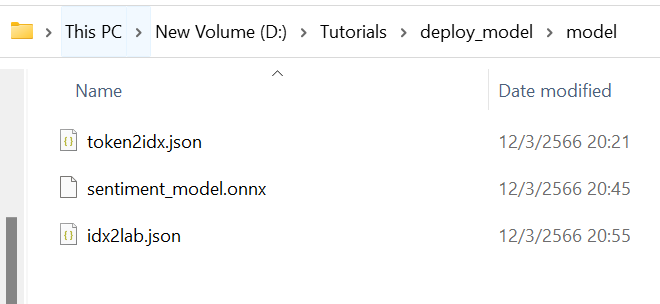

รันคำสั่งที่ เครื่องตัวเอง

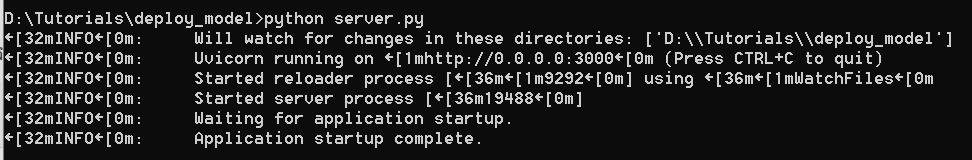

จากนั้ก็ลองเข้าหน้าเว็บเพื่อทดสอบ

## สร้างหน้าเว็บเพื่อเรียกใช้้ API อย่างง่าย

ลองสร้างไฟล์ index.html แล้วเพิ่มโค้ด ดังนี้เพื่อเรียกใช้งาน API

```
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Thai Sentiment Analysis</title>
  <!-- Bootstrap CSS -->
  <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.2/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-EVSTQN3/azprG1Anm3QDgpJLIm9Nao0Yz1ztcQTwFspd3yD65VohhpuuCOmLASjC" crossorigin="anonymous">

<style>
.Positive{
    color: #28B463
}
.Negative{
    color: #E74C3C  
}

.result{
    font-size: 24px;
}
</style>

</head>
<body>
  <div class="container mt-5">
  <h1>Thai Sentiment Analysis</h1>
    <form id="myForm">
      <div class="mb-3 mt-5">
        <label for="input-text" class="form-label">Enter some text:</label>
        <textarea type="text" class="form-control" id="input-text" placeholder="Type here..."> </textarea>
        <div calss="result" id="result"></div>
      </div>
      <button type="submit" class="btn btn-primary">Submit</button>
    </form>
  </div>
  <!-- Bootstrap JavaScript -->
  <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.0.2/dist/js/bootstrap.bundle.min.js" integrity="sha384-MrcW6ZMFYlzcLA8Nl+NtUVF0sA7MsXsP1UyJoMp4YLEuNSfAP+JcXn/tWtIaxVXM" crossorigin="anonymous"></script>
  <!-- jQuery -->
  <script src="https://code.jquery.com/jquery-3.6.4.min.js" crossorigin="anonymous" referrerpolicy="no-referrer"></script>
  
  <script>
    $(document).ready(function() {
      $("#myForm").submit(function(event) {
        event.preventDefault(); // Prevent form from submitting normally
        var inputText = $("#input-text").val(); // Get input value
        $.ajax({
          type: "POST",
          contentType: "application/json",
          url: "http://localhost:3000/predict", // Replace with your API endpoint URL
          data: JSON.stringify({ text: inputText }), // Pass input value as data to API
          dataType: 'json',
          success: function(response) {
            alert("Data submitted successfully!"); // Show success message
            console.log(response);
           // $("#input-text").val(""); // Clear input field
            $("#result").html("<div class='"+response.prediction+"''>"+response.prediction+"</div>");
          },
          error: function(jqXHR, textStatus, errorThrown) {
            alert("Error submitting data: " + errorThrown); // Show error message
          }
        });
      });
    });
  </script>
</body>
</html>



```



ของ API แล้วลองรัน

`python -m http.server`

จะได้ผลลัพธ์ ดังรูป


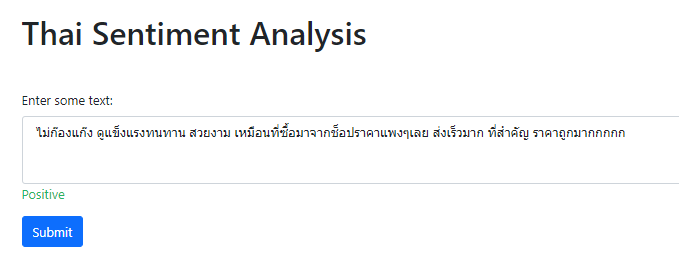